# Downloading dependencies

/*
 * Copyright (C) 2025 Barneel Ray
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, either version 3 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License
 * along with this program. If not, see <https://www.gnu.org/licenses/>.
 */


Sixty seconds of data were recorded from two subjects (1 male, and 1 female, aged 20-22) for each of the 6 film clips, producing 12 minutes (720 seconds) of brain activity data (6 minutes for each emotional state). Six minutes of neutral brainwave data were also collected, resulting in a total of 36 minutes of EEG data. With the signals downsampled to 150 Hz, this produced a dataset of 324,000 data points collected from the brainwaves.

Then, statistical functions (mean, min, max, correlation, FFT, logarithmic, etc.) are calculated over the data points when a sliding window of 1 second, beginning at t = 0 and t = 0.5s, is moved over the raw signals. This process creates a total of 2,548 feature columns, with a final column for labels.

The columns having a and b may refer to the two electrodes in the muse band eeg headset and the fft_XXX_a or fft_XXX_b may refer to the fft based component extracted at XXX timestamp at electrode a or b.

In [1]:
!pip install pywavelets tensorflow scipy scikit-learn pandas numpy
!pip install xgboost

In [2]:
!pip install imblearn

In [3]:
!pip install pandas

# Loading Dataset and basic libraries for data manipulation.

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
emotions=pd.read_csv("/content/emotions (2).csv")

In [7]:
emotions.describe()
print(emotions.shape)

(2132, 2549)


# Data cleaning and preprocessing.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
# ==========================
# 1. LOAD DATA & PREPROCESSING
# ==========================
df = emotions  # Update file path accordingly
X = df.drop(columns=['label'])        # Adjust column name if necessary
y = df['label']

# Fix negative values (if meaningful, take absolute values)
X = X.abs()

# Replace infinite values with NaN and then fill with column median
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# Handle outliers using the IQR method (without removing rows)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Define reasonable bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip outlier values to be within bounds
X = X.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Scale all values to [0,1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print("Encoding complete")

print("Preprocessing complete: negatives fixed, infinities handled, missing values filled, outliers clipped, and scaling applied.")

Encoding complete
Preprocessing complete: negatives fixed, infinities handled, missing values filled, outliers clipped, and scaling applied.


# Feature Augmentation

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from scipy.stats import entropy
import warnings
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score

# Import classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from collections import Counter
warnings.filterwarnings("ignore")

# ==========================
# 1. FEATURE AUGMENTATION
# ==========================
def augment_features(df):
    augmented_df = df.copy()

    # Statistical features
    augmented_df['mean'] = df.mean(axis=1)
    augmented_df['std'] = df.std(axis=1)
    augmented_df['min'] = df.min(axis=1)
    augmented_df['max'] = df.max(axis=1)
    augmented_df['median'] = df.median(axis=1)
    augmented_df['kurtosis'] = df.kurtosis(axis=1)
    augmented_df['skewness'] = df.skew(axis=1)
    augmented_df['energy'] = (df ** 2).sum(axis=1)
    augmented_df['entropy'] = -(df.clip(lower=1e-10) * np.log1p(df.clip(lower=1e-10))).sum(axis=1)

    # Frequency domain features (FFT-based)
    fft_features = np.fft.fft(df, axis=1)
    augmented_df['fft_mean'] = np.mean(np.abs(fft_features), axis=1)
    augmented_df['fft_std'] = np.std(np.abs(fft_features), axis=1)
    augmented_df['fft_energy'] = np.sum(np.abs(fft_features) ** 2, axis=1)

    # Moving average features (window sizes: 3, 5, 10)
    for window in [3, 5, 10]:
        augmented_df[f'moving_avg_{window}'] = df.rolling(window=window, axis=1).mean().mean(axis=1)

    # Differential features
    augmented_df['diff_mean'] = df.diff(axis=1).mean(axis=1)
    augmented_df['diff_std'] = df.diff(axis=1).std(axis=1)
    augmented_df['diff_energy'] = (df.diff(axis=1) ** 2).sum(axis=1)

    # Wavelet Transform Features (using DWT with fixed length extraction)
    def extract_wavelet_features(row):
        coeffs = pywt.dwt(row, 'db1')
        return np.hstack(coeffs)[:10]  # Fixed length of 10
    wavelet_features = df.apply(extract_wavelet_features, axis=1, result_type='expand')
    wavelet_features.columns = [f'wavelet_{i}' for i in range(wavelet_features.shape[1])]
    augmented_df = pd.concat([augmented_df, wavelet_features], axis=1)

    print(f'Feature augmentation complete. Original features: {df.shape[1]}, New features: {augmented_df.shape[1]}')
    return augmented_df

# ==========================
# 2. PREPROCESSING: FILTER, SPLIT & SCALE
# ==========================
# Calculate counts of each class
counts = Counter(y)

# Filter samples where class count > 1
mask = np.array([counts[label] > 1 for label in y])
X_filtered = X[mask]
y_filtered = y[mask]

# Augment features on the filtered data
X_augmented = augment_features(X_filtered)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_augmented)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_filtered, test_size=0.1, stratify=y_filtered, random_state=42)

print("Splitting of data complete")
print("Feature scaling complete")


Feature augmentation complete. Original features: 2548, New features: 2576
Splitting of data complete
Feature scaling complete


# Using feature extracted data on priorly designed custom haee with mulit headed attention layer.

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 0.Apply SMOTE on Training Set if needed
# -----------------------------
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

# -----------------------------
# 1. XGB-based Feature Selection and Reshaping
# -----------------------------
# Assume X_train and X_test are predefined, already scaled and label encoded.
# Train an XGBClassifier to determine feature importance.
xgb_fs = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_fs.fit(X_train, y_train)

# Get the feature importances and select top 200 indices
importances = xgb_fs.feature_importances_
indices = np.argsort(importances)[::-1][:200]

# Reduce features to top 200 for training and test sets
X_train_reduced = X_train[:, indices]
X_test_reduced  = X_test[:, indices]

# Reshape for Conv1D: (samples, 200, 1)
X_train_reduced_reshaped = X_train_reduced.reshape(-1, 200, 1)
X_test_reduced_reshaped  = X_test_reduced.reshape(-1, 200, 1)

# n_classes is determined from your label encoding
n_classes = len(np.unique(y_train))

# -----------------------------
# 2. Define Custom Multi-Head Attention Layer & HAEE Model
# -----------------------------
class MultiHeadAttention(Layer):
    def __init__(self, heads=4, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0, "d_model must be divisible by the number of heads"
        self.depth = self.d_model // self.heads

        self.Wq = self.add_weight(name='query', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name='key', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name='value', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(name='output', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        super(MultiHeadAttention, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = inputs.shape[1]

        # Linear transformations
        q = K.dot(inputs, self.Wq)
        k = K.dot(inputs, self.Wk)
        v = K.dot(inputs, self.Wv)

        # Split into heads
        q = tf.reshape(q, (batch_size, seq_len, self.heads, self.depth))
        k = tf.reshape(k, (batch_size, seq_len, self.heads, self.depth))
        v = tf.reshape(v, (batch_size, seq_len, self.heads, self.depth))

        # Transpose for attention: (batch, heads, seq_len, depth)
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])

        # Scaled dot-product attention
        scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(scores, axis=-1)
        out = tf.matmul(attention, v)

        # Concatenate heads
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, seq_len, self.d_model))

        # Final linear transformation
        out = K.dot(out, self.Wo)
        return out

def create_enhanced_haee_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
    x = Conv1D(32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)
    x = Dropout(0.3)(x)
    x = MultiHeadAttention(heads=4)(x)

    # Global Average Pooling to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# -----------------------------
# 3. Stratified K-Fold Cross Validation on Predefined X_train and y_train
# -----------------------------
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
all_train_y = []
all_train_y_pred_proba = []
all_valid_y = []
all_valid_y_pred_proba = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_reduced_reshaped, y_train)):
    print(f"\n--- Fold {fold+1} ---")
    X_train_fold = X_train_reduced_reshaped[train_idx]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train_reduced_reshaped[valid_idx]
    y_valid_fold = y_train[valid_idx]

    # Create HAEE model for this fold
    model = create_enhanced_haee_model((200, 1))

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32,
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=callbacks, verbose=0)

    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    training_accuracies.append(best_train_acc)
    validation_accuracies.append(best_val_acc)
    print(f"Best Training Accuracy in fold: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy in fold: {best_val_acc:.4f}")

    # Extract CNN features (assume penultimate Dense layer is at index -3; adjust if needed)
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    cnn_features_train = feature_extractor.predict(X_train_fold, verbose=0)
    cnn_features_valid = feature_extractor.predict(X_valid_fold, verbose=0)

    # Instead of using XGB on CNN features, we're now using it solely for feature selection earlier.
    # Here, we simply use an XGBClassifier to refine performance on the reduced CNN features.
    xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                        eval_metric='mlogloss', random_state=42)
    xgb.fit(cnn_features_train, y_train_fold)

    # Get prediction probabilities for ROC analysis
    y_train_pred_proba = xgb.predict_proba(cnn_features_train)
    y_valid_pred_proba = xgb.predict_proba(cnn_features_valid)

    all_train_y.extend(y_train_fold)
    all_train_y_pred_proba.extend(y_train_pred_proba)
    all_valid_y.extend(y_valid_fold)
    all_valid_y_pred_proba.extend(y_valid_pred_proba)

    y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)
    valid_acc = accuracy_score(y_valid_fold, y_valid_pred)
    testing_accuracies.append(valid_acc)
    print(f"Validation Accuracy (via XGB for feature selection to be fed into CNN): {valid_acc:.4f}")

# -----------------------------
# 4. Plot ROC Curves for Validation and Training Data
# -----------------------------
# Validation ROC Curves
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_valid_y = np.array(all_valid_y)
all_valid_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_valid_y == i, all_valid_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Validation ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Training ROC Curves
plt.figure(figsize=(10, 8))
all_train_y = np.array(all_train_y)
all_train_y_pred_proba = np.array(all_train_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_train_y == i, all_train_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Training ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Overall Performance Summary
# -----------------------------
print("\n--- Overall Performance ---")
print(f"Mean Training Accuracy: {np.mean(training_accuracies):.4f} ± {np.std(training_accuracies):.4f}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracies):.4f} ± {np.std(validation_accuracies):.4f}")
print(f"Mean Testing Accuracy: {np.mean(testing_accuracies):.4f} ± {np.std(testing_accuracies):.4f}")

all_valid_y_pred = np.argmax(np.array(all_valid_y_pred_proba), axis=1)
print("\nClassification Report on Validation Data:")
print(classification_report(np.array(all_valid_y), all_valid_y_pred))


--- Fold 1 ---
Best Training Accuracy in fold: 0.9107
Best Validation Accuracy in fold: 0.8966
Validation Accuracy (via XGB for feature selection to be fed into CNN): 0.9121

--- Fold 2 ---


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. Plot Test ROC Curves
# -----------------------------
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_test_y = np.array(all_valid_y)  # Assuming validation as test
all_test_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_test_y == i, all_test_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Test ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 2. Classification Reports
# -----------------------------
all_train_y_pred = np.argmax(np.array(all_train_y_pred_proba), axis=1)
all_test_y_pred = np.argmax(np.array(all_test_y_pred_proba), axis=1)

print("\nClassification Report on Training Data:")
print(classification_report(np.array(all_train_y), all_train_y_pred))

print("\nClassification Report on Test Data:")
print(classification_report(np.array(all_test_y), all_test_y_pred))

# -----------------------------
# 3. Confusion Matrices
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

plot_confusion_matrix(np.array(all_train_y), all_train_y_pred, "Training Confusion Matrix")
plot_confusion_matrix(np.array(all_valid_y), all_valid_y_pred, "Validation Confusion Matrix")
plot_confusion_matrix(np.array(all_test_y), all_test_y_pred, "Test Confusion Matrix")

# -----------------------------
# 4. Accuracy vs Loss Curve
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Including branching in the architecture of the custom haee net with multi headed attention layer.

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------
# 0.Apply SMOTE on Training Set if needed
# -----------------------------
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

# -----------------------------
# 1.XGB-based Feature Selection and Reshaping
# -----------------------------
# Assume X_train and X_test are predefined, already scaled and label encoded.
# Train an XGBClassifier to determine feature importance.
xgb_fs = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_fs.fit(X_train, y_train)

# Get the feature importances and select top 200 indices
importances = xgb_fs.feature_importances_
indices = np.argsort(importances)[::-1][:200]

# Reduce features to top 200 for training and test sets
X_train_reduced = X_train[:, indices]
X_test_reduced  = X_test[:, indices]

# Reshape for Conv1D: (samples, 200, 1)
X_train_reduced_reshaped = X_train_reduced.reshape(-1, 200, 1)
X_test_reduced_reshaped  = X_test_reduced.reshape(-1, 200, 1)

# n_classes is determined from your label encoding
n_classes = len(np.unique(y_train))

# -----------------------------
# 2. Define Custom Multi-Head Attention Layer & HAEE Model
# -----------------------------
class MultiHeadAttention(Layer):
    def __init__(self, heads=4, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0, "d_model must be divisible by the number of heads"
        self.depth = self.d_model // self.heads

        self.Wq = self.add_weight(name='query', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name='key', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name='value', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(name='output', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        super(MultiHeadAttention, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = inputs.shape[1]

        # Linear transformations
        q = K.dot(inputs, self.Wq)
        k = K.dot(inputs, self.Wk)
        v = K.dot(inputs, self.Wv)

        # Split into heads
        q = tf.reshape(q, (batch_size, seq_len, self.heads, self.depth))
        k = tf.reshape(k, (batch_size, seq_len, self.heads, self.depth))
        v = tf.reshape(v, (batch_size, seq_len, self.heads, self.depth))

        # Transpose for attention: (batch, heads, seq_len, depth)
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])

        # Scaled dot-product attention
        scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(scores, axis=-1)
        out = tf.matmul(attention, v)

        # Concatenate heads
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, seq_len, self.d_model))

        # Final linear transformation
        out = K.dot(out, self.Wo)
        return out

def create_enhanced_haee_model(input_shape, n_classes=3):
    inputs = Input(shape=input_shape)

    # Main HAEE pipeline (Keeping original structure)
    x1 = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x1)

    x1 = Conv1D(32, kernel_size=3, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x1)
    x1 = Dropout(0.3)(x1)

    # 6 Branches with Different Kernels
    branch1 = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x1)
    branch2 = Conv1D(32, kernel_size=5, padding='same', activation='relu')(x1)
    branch3 = Conv1D(32, kernel_size=7, padding='same', activation='relu')(x1)
    branch4 = Conv1D(32, kernel_size=3, dilation_rate=2, padding='same', activation='relu')(x1)
    branch5 = Conv1D(32, kernel_size=5, dilation_rate=2, padding='same', activation='relu')(x1)
    branch6 = Conv1D(32, kernel_size=1, padding='same', activation='relu')(x1)

    # Merge all branches
    merged = Concatenate()([x1, branch1, branch2, branch3, branch4, branch5, branch6])

    # Multi-Head Attention (Fix with key_dim)
    attended = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(merged, merged)

    # Concatenate attention output
    combined = Concatenate()([merged, attended])

    # Pooling and fully connected layers
    pooled = GlobalAveragePooling1D()(combined)
    x = Dense(128, activation='relu')(pooled)
    x = BatchNormalization()(x)  # Extra stability
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    # Define & compile model
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model
# -----------------------------
# 3. Stratified K-Fold Cross Validation on Predefined X_train and y_train
# -----------------------------
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
all_train_y = []
all_train_y_pred_proba = []
all_valid_y = []
all_valid_y_pred_proba = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_reduced_reshaped, y_train)):
    print(f"\n--- Fold {fold+1} ---")
    X_train_fold = X_train_reduced_reshaped[train_idx]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train_reduced_reshaped[valid_idx]
    y_valid_fold = y_train[valid_idx]

    # Create HAEE model for this fold
    model = create_enhanced_haee_model((200, 1))

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32,
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=callbacks, verbose=0)

    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    training_accuracies.append(best_train_acc)
    validation_accuracies.append(best_val_acc)
    print(f"Best Training Accuracy in fold: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy in fold: {best_val_acc:.4f}")

    # Extract CNN features (assume penultimate Dense layer is at index -3; adjust if needed)
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    cnn_features_train = feature_extractor.predict(X_train_fold, verbose=0)
    cnn_features_valid = feature_extractor.predict(X_valid_fold, verbose=0)

    # Instead of using XGB on CNN features, we're now using it solely for feature selection earlier.
    # Here, we simply use an XGBClassifier to refine performance on the reduced CNN features.
    xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                        eval_metric='mlogloss', random_state=42)
    xgb.fit(cnn_features_train, y_train_fold)

    # Get prediction probabilities for ROC analysis
    y_train_pred_proba = xgb.predict_proba(cnn_features_train)
    y_valid_pred_proba = xgb.predict_proba(cnn_features_valid)

    all_train_y.extend(y_train_fold)
    all_train_y_pred_proba.extend(y_train_pred_proba)
    all_valid_y.extend(y_valid_fold)
    all_valid_y_pred_proba.extend(y_valid_pred_proba)

    y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)
    valid_acc = accuracy_score(y_valid_fold, y_valid_pred)
    testing_accuracies.append(valid_acc)
    print(f"Validation Accuracy (via XGB for feature selection to be fed into CNN): {valid_acc:.4f}")

# -----------------------------
# 4. Plot ROC Curves for Validation and Training Data
# -----------------------------
# Validation ROC Curves
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_valid_y = np.array(all_valid_y)
all_valid_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_valid_y == i, all_valid_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Validation ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Training ROC Curves
plt.figure(figsize=(10, 8))
all_train_y = np.array(all_train_y)
all_train_y_pred_proba = np.array(all_train_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_train_y == i, all_train_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Training ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Overall Performance Summary
# -----------------------------
print("\n--- Overall Performance ---")
print(f"Mean Training Accuracy: {np.mean(training_accuracies):.4f} ± {np.std(training_accuracies):.4f}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracies):.4f} ± {np.std(validation_accuracies):.4f}")
print(f"Mean Testing Accuracy: {np.mean(testing_accuracies):.4f} ± {np.std(testing_accuracies):.4f}")

all_valid_y_pred = np.argmax(np.array(all_valid_y_pred_proba), axis=1)
print("\nClassification Report on Validation Data:")
print(classification_report(np.array(all_valid_y), all_valid_y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. Plot Test ROC Curves
# -----------------------------
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_test_y = np.array(all_valid_y)  # Assuming validation as test
all_test_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_test_y == i, all_test_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Test ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 2. Classification Reports
# -----------------------------
all_train_y_pred = np.argmax(np.array(all_train_y_pred_proba), axis=1)
all_test_y_pred = np.argmax(np.array(all_test_y_pred_proba), axis=1)

print("\nClassification Report on Training Data:")
print(classification_report(np.array(all_train_y), all_train_y_pred))

print("\nClassification Report on Test Data:")
print(classification_report(np.array(all_test_y), all_test_y_pred))

# -----------------------------
# 3. Confusion Matrices
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

plot_confusion_matrix(np.array(all_train_y), all_train_y_pred, "Training Confusion Matrix")
plot_confusion_matrix(np.array(all_valid_y), all_valid_y_pred, "Validation Confusion Matrix")
plot_confusion_matrix(np.array(all_test_y), all_test_y_pred, "Test Confusion Matrix")

# -----------------------------
# 4. Accuracy vs Loss Curve
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Modifying the loss function for better learning in class 0 and 2 (Focal Loss)

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0)
        loss = -y_true * alpha * ((1 - y_pred) ** gamma) * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss

# -----------------------------
# 0.Apply SMOTE on Training Set if needed
# -----------------------------
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

# -----------------------------
# 1.XGB-based Feature Selection and Reshaping
# -----------------------------
# Assume X_train and X_test are predefined, already scaled and label encoded.
# Train an XGBClassifier to determine feature importance.
xgb_fs = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_fs.fit(X_train, y_train)

# Get the feature importances and select top 200 indices
importances = xgb_fs.feature_importances_
indices = np.argsort(importances)[::-1][:200]

# Reduce features to top 200 for training and test sets
X_train_reduced = X_train[:, indices]
X_test_reduced  = X_test[:, indices]

# Reshape for Conv1D: (samples, 200, 1)
X_train_reduced_reshaped = X_train_reduced.reshape(-1, 200, 1)
X_test_reduced_reshaped  = X_test_reduced.reshape(-1, 200, 1)

# n_classes is determined from your label encoding
n_classes = len(np.unique(y_train))

# -----------------------------
# 2. Define Custom Multi-Head Attention Layer & HAEE Model
# -----------------------------
class MultiHeadAttention(Layer):
    def __init__(self, heads=4, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0, "d_model must be divisible by the number of heads"
        self.depth = self.d_model // self.heads

        self.Wq = self.add_weight(name='query', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name='key', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name='value', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(name='output', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        super(MultiHeadAttention, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = inputs.shape[1]

        # Linear transformations
        q = K.dot(inputs, self.Wq)
        k = K.dot(inputs, self.Wk)
        v = K.dot(inputs, self.Wv)

        # Split into heads
        q = tf.reshape(q, (batch_size, seq_len, self.heads, self.depth))
        k = tf.reshape(k, (batch_size, seq_len, self.heads, self.depth))
        v = tf.reshape(v, (batch_size, seq_len, self.heads, self.depth))

        # Transpose for attention: (batch, heads, seq_len, depth)
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])

        # Scaled dot-product attention
        scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(scores, axis=-1)
        out = tf.matmul(attention, v)

        # Concatenate heads
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, seq_len, self.d_model))

        # Final linear transformation
        out = K.dot(out, self.Wo)
        return out

def create_enhanced_haee_model(input_shape, n_classes=3):
    inputs = Input(shape=input_shape)

    # Main HAEE pipeline (Keeping original structure)
    x1 = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x1)

    x1 = Conv1D(32, kernel_size=3, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x1)
    x1 = Dropout(0.3)(x1)

    # 6 Branches with Different Kernels
    branch1 = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x1)
    branch2 = Conv1D(32, kernel_size=5, padding='same', activation='relu')(x1)
    branch3 = Conv1D(32, kernel_size=7, padding='same', activation='relu')(x1)
    branch4 = Conv1D(32, kernel_size=3, dilation_rate=2, padding='same', activation='relu')(x1)
    branch5 = Conv1D(32, kernel_size=5, dilation_rate=2, padding='same', activation='relu')(x1)
    branch6 = Conv1D(32, kernel_size=1, padding='same', activation='relu')(x1)

    # Merge all branches
    merged = Concatenate()([x1, branch1, branch2, branch3, branch4, branch5, branch6])

    # Multi-Head Attention (Fix with key_dim)
    attended = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(merged, merged)

    # Concatenate attention output
    combined = Concatenate()([merged, attended])

    # Pooling and fully connected layers
    pooled = GlobalAveragePooling1D()(combined)
    x = Dense(128, activation='relu')(pooled)
    x = BatchNormalization()(x)  # Extra stability
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    # Define & compile model
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=focal_loss(alpha=0.25, gamma=2.0),  # <-- Replace here
              metrics=['accuracy'])
    return model
# -----------------------------
# 3. Stratified K-Fold Cross Validation on Predefined X_train and y_train
# -----------------------------
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
all_train_y = []
all_train_y_pred_proba = []
all_valid_y = []
all_valid_y_pred_proba = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_reduced_reshaped, y_train)):
    print(f"\n--- Fold {fold+1} ---")
    X_train_fold = X_train_reduced_reshaped[train_idx]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train_reduced_reshaped[valid_idx]
    y_valid_fold = y_train[valid_idx]

    # Create HAEE model for this fold
    model = create_enhanced_haee_model((200, 1))

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32,
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=callbacks, verbose=0)

    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    training_accuracies.append(best_train_acc)
    validation_accuracies.append(best_val_acc)
    print(f"Best Training Accuracy in fold: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy in fold: {best_val_acc:.4f}")

    # Extract CNN features (assume penultimate Dense layer is at index -3; adjust if needed)
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    cnn_features_train = feature_extractor.predict(X_train_fold, verbose=0)
    cnn_features_valid = feature_extractor.predict(X_valid_fold, verbose=0)

    # Instead of using XGB on CNN features, we're now using it solely for feature selection earlier.
    # Here, we simply use an XGBClassifier to refine performance on the reduced CNN features.
    xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                        eval_metric='mlogloss', random_state=42)
    xgb.fit(cnn_features_train, y_train_fold)

    # Get prediction probabilities for ROC analysis
    y_train_pred_proba = xgb.predict_proba(cnn_features_train)
    y_valid_pred_proba = xgb.predict_proba(cnn_features_valid)

    all_train_y.extend(y_train_fold)
    all_train_y_pred_proba.extend(y_train_pred_proba)
    all_valid_y.extend(y_valid_fold)
    all_valid_y_pred_proba.extend(y_valid_pred_proba)

    y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)
    valid_acc = accuracy_score(y_valid_fold, y_valid_pred)
    testing_accuracies.append(valid_acc)
    print(f"Validation Accuracy (via XGB for feature selection to be fed into CNN): {valid_acc:.4f}")

# -----------------------------
# 4. Plot ROC Curves for Validation and Training Data
# -----------------------------
# Validation ROC Curves
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_valid_y = np.array(all_valid_y)
all_valid_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_valid_y == i, all_valid_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Validation ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Training ROC Curves
plt.figure(figsize=(10, 8))
all_train_y = np.array(all_train_y)
all_train_y_pred_proba = np.array(all_train_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_train_y == i, all_train_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Training ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Overall Performance Summary
# -----------------------------
print("\n--- Overall Performance ---")
print(f"Mean Training Accuracy: {np.mean(training_accuracies):.4f} ± {np.std(training_accuracies):.4f}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracies):.4f} ± {np.std(validation_accuracies):.4f}")
print(f"Mean Testing Accuracy: {np.mean(testing_accuracies):.4f} ± {np.std(testing_accuracies):.4f}")

all_valid_y_pred = np.argmax(np.array(all_valid_y_pred_proba), axis=1)
print("\nClassification Report on Validation Data:")
print(classification_report(np.array(all_valid_y), all_valid_y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. Plot Test ROC Curves
# -----------------------------
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_test_y = np.array(all_valid_y)  # Assuming validation as test
all_test_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_test_y == i, all_test_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Test ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 2. Classification Reports
# -----------------------------
all_train_y_pred = np.argmax(np.array(all_train_y_pred_proba), axis=1)
all_test_y_pred = np.argmax(np.array(all_test_y_pred_proba), axis=1)

print("\nClassification Report on Training Data:")
print(classification_report(np.array(all_train_y), all_train_y_pred))

print("\nClassification Report on Test Data:")
print(classification_report(np.array(all_test_y), all_test_y_pred))

# -----------------------------
# 3. Confusion Matrices
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

plot_confusion_matrix(np.array(all_train_y), all_train_y_pred, "Training Confusion Matrix")
plot_confusion_matrix(np.array(all_valid_y), all_valid_y_pred, "Validation Confusion Matrix")
plot_confusion_matrix(np.array(all_test_y), all_test_y_pred, "Test Confusion Matrix")

# -----------------------------
# 4. Accuracy vs Loss Curve
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Modifying the loss function for better learining of classes 0 and 2 ( Class balanced cross entropy)

[1504 2567 2566 2565  664  515 1643  108  163 1274 1630  256  369 1588
  262 1628   61  230  132 1406 1335  275  173  249 2229  142 1446 1442
  375   92 1798  518 1334 2365 1447   60  177  245  152    0 1452  654
 1704  969 1631 1283 2572 1278 2564 1111 2574 1646  127 1771 1427   90
  154 1365 1140  146  210  535   62  118    5 2409   74  821 2218   12
  477    4  214  113  161  178   52 1395    2 1448 1858 1449 1431 1277
  724 1443 1377  497  895 2313  710   22    1 1318 1589 1317  172 1350
 1415  101  266  316  354   28   29 1445 1302   77   27  447  187  179
  153 2189  854 2523  880    7 1276    3  124  165  160   20 1174 1461
   21 1270  103 1099  116   13 1678  604 2505 1375 1700  691 1426 1601
  239 1059 1392  151 2552 1536 1814   94 2553  171  546  255   14  590
   63    8  361   35  685 1385    6 2413 1297 1339 1864  640 2345 1787
  473  790 1299 1567 1479   58  749 1015  488 1414   93  167 1510 1539
 1410 1803   65  148  292 1463  367 1436 2259  476  457 1296 1412  133
  469 

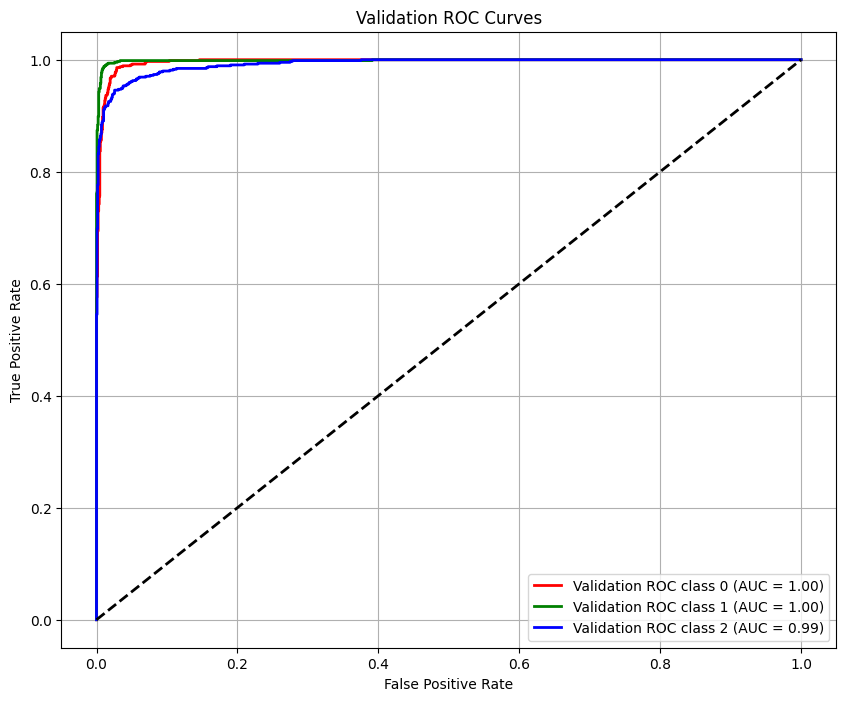

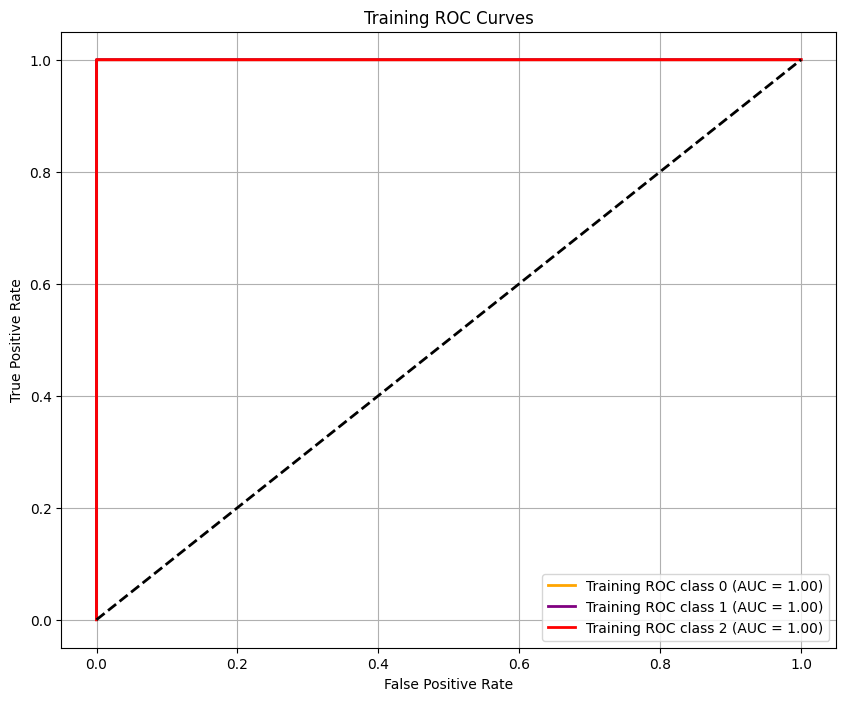


--- Overall Performance ---
Mean Training Accuracy: 0.9802 ± 0.0041
Mean Validation Accuracy: 0.9700 ± 0.0089
Mean Testing Accuracy: 0.9632 ± 0.0103

Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       644
           1       0.98      0.98      0.98       644
           2       0.95      0.94      0.94       644

    accuracy                           0.96      1932
   macro avg       0.96      0.96      0.96      1932
weighted avg       0.96      0.96      0.96      1932



In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Layer, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)
def get_class_balanced_weights(y_train, beta=0.99):
    """
    Compute class-balanced weights based on the effective number of samples.
    """
    class_counts = np.bincount(y_train)
    effective_num = (1 - beta ** class_counts) / (1 - beta)
    weights = 1.0 / effective_num
    weights /= np.sum(weights)  # Normalize weights
    return weights
def class_balanced_loss(weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)

        # Ensure y_true is one-hot encoded
        if len(y_true.shape) == 1:  # If not one-hot encoded
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))

        weight_vector = tf.reduce_sum(y_true * weights, axis=-1)  # Fix reduction axis
        cce = tf.keras.losses.CategoricalCrossentropy()
        base_loss = cce(y_true, y_pred)
        return tf.reduce_mean(weight_vector * base_loss)
    return loss

# -----------------------------
# 0.Apply SMOTE on Training Set if needed
# -----------------------------
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

# -----------------------------
# 1.XGB-based Feature Selection and Reshaping
# -----------------------------
# Assume X_train and X_test are predefined, already scaled and label encoded.
# Train an XGBClassifier to determine feature importance.
xgb_fs = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_fs.fit(X_train, y_train)

# Get the feature importances and select top 200 indices
importances = xgb_fs.feature_importances_
indices = np.argsort(importances)[::-1][:200]
print(indices)

# Reduce features to top 200 for training and test sets
X_train_reduced = X_train[:, indices]
X_test_reduced  = X_test[:, indices]

# Reshape for Conv1D: (samples, 200, 1)
X_train_reduced_reshaped = X_train_reduced.reshape(-1, 200, 1)
X_test_reduced_reshaped  = X_test_reduced.reshape(-1, 200, 1)

# n_classes is determined from your label encoding
n_classes = len(np.unique(y_train))

# -----------------------------
# 2. Define Custom Multi-Head Attention Layer & HAEE Model
# -----------------------------
class MultiHeadAttention(Layer):
    def __init__(self, heads=4, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0, "d_model must be divisible by the number of heads"
        self.depth = self.d_model // self.heads

        self.Wq = self.add_weight(name='query', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(name='key', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(name='value', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(name='output', shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform', trainable=True)
        super(MultiHeadAttention, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = inputs.shape[1]

        # Linear transformations
        q = K.dot(inputs, self.Wq)
        k = K.dot(inputs, self.Wk)
        v = K.dot(inputs, self.Wv)

        # Split into heads
        q = tf.reshape(q, (batch_size, seq_len, self.heads, self.depth))
        k = tf.reshape(k, (batch_size, seq_len, self.heads, self.depth))
        v = tf.reshape(v, (batch_size, seq_len, self.heads, self.depth))

        # Transpose for attention: (batch, heads, seq_len, depth)
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])

        # Scaled dot-product attention
        scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(scores, axis=-1)
        out = tf.matmul(attention, v)

        # Concatenate heads
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, seq_len, self.d_model))

        # Final linear transformation
        out = K.dot(out, self.Wo)
        return out

def create_enhanced_haee_model(input_shape, n_classes=3):
    inputs = Input(shape=input_shape)

    # Main HAEE pipeline (Keeping original structure)
    x1 = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x1)

    x1 = Conv1D(32, kernel_size=3, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x1)
    x1 = Dropout(0.3)(x1)

    # 6 Branches with Different Kernels
    branch1 = Conv1D(32, kernel_size=3, padding='same', activation='relu')(x1)
    branch2 = Conv1D(32, kernel_size=5, padding='same', activation='relu')(x1)
    branch3 = Conv1D(32, kernel_size=7, padding='same', activation='relu')(x1)
    branch4 = Conv1D(32, kernel_size=3, dilation_rate=2, padding='same', activation='relu')(x1)
    branch5 = Conv1D(32, kernel_size=5, dilation_rate=2, padding='same', activation='relu')(x1)
    branch6 = Conv1D(32, kernel_size=1, padding='same', activation='relu')(x1)

    # Merge all branches
    merged = Concatenate()([x1, branch1, branch2, branch3, branch4, branch5, branch6])

    # Multi-Head Attention (Fix with key_dim)
    attended = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(merged, merged)

    # Concatenate attention output
    combined = Concatenate()([merged, attended])

    # Pooling and fully connected layers
    pooled = GlobalAveragePooling1D()(combined)
    x = Dense(128, activation='relu')(pooled)
    x = BatchNormalization()(x)  # Extra stability
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)

    # Define & compile model
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=class_balanced_loss(weights=tf.constant(class_weights, dtype=tf.float32)),
              metrics=['accuracy'])
    return model
# -----------------------------
# 3. Stratified K-Fold Cross Validation on Predefined X_train and y_train
# -----------------------------
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
all_train_y = []
all_train_y_pred_proba = []
all_valid_y = []
all_valid_y_pred_proba = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_reduced_reshaped, y_train)):
    print(f"\n--- Fold {fold+1} ---")
    X_train_fold = X_train_reduced_reshaped[train_idx]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train_reduced_reshaped[valid_idx]
    y_valid_fold = y_train[valid_idx]
    class_weights = get_class_balanced_weights(y_train_fold)
    # Create HAEE model for this fold
    model = create_enhanced_haee_model((200, 1))

    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=300, batch_size=32,
                        validation_data=(X_valid_fold, y_valid_fold),
                        callbacks=callbacks, verbose=0)

    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    training_accuracies.append(best_train_acc)
    validation_accuracies.append(best_val_acc)
    print(f"Best Training Accuracy in fold: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy in fold: {best_val_acc:.4f}")

    # Extract CNN features (assume penultimate Dense layer is at index -3; adjust if needed)
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    cnn_features_train = feature_extractor.predict(X_train_fold, verbose=0)
    cnn_features_valid = feature_extractor.predict(X_valid_fold, verbose=0)

    # Instead of using XGB on CNN features, we're now using it solely for feature selection earlier.
    # Here, we simply use an XGBClassifier to refine performance on the reduced CNN features.
    xgb = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1,
                        eval_metric='mlogloss', random_state=42)
    xgb.fit(cnn_features_train, y_train_fold)

    # Get prediction probabilities for ROC analysis
    y_train_pred_proba = xgb.predict_proba(cnn_features_train)
    y_valid_pred_proba = xgb.predict_proba(cnn_features_valid)

    all_train_y.extend(y_train_fold)
    all_train_y_pred_proba.extend(y_train_pred_proba)
    all_valid_y.extend(y_valid_fold)
    all_valid_y_pred_proba.extend(y_valid_pred_proba)

    y_valid_pred = np.argmax(y_valid_pred_proba, axis=1)
    valid_acc = accuracy_score(y_valid_fold, y_valid_pred)
    testing_accuracies.append(valid_acc)
    print(f"Validation Accuracy (via XGB for feature selection to be fed into CNN): {valid_acc:.4f}")

# -----------------------------
# 4. Plot ROC Curves for Validation and Training Data
# -----------------------------
# Validation ROC Curves
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_valid_y = np.array(all_valid_y)
all_valid_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_valid_y == i, all_valid_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Validation ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Training ROC Curves
plt.figure(figsize=(10, 8))
all_train_y = np.array(all_train_y)
all_train_y_pred_proba = np.array(all_train_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_train_y == i, all_train_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Training ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Overall Performance Summary
# -----------------------------
print("\n--- Overall Performance ---")
print(f"Mean Training Accuracy: {np.mean(training_accuracies):.4f} ± {np.std(training_accuracies):.4f}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracies):.4f} ± {np.std(validation_accuracies):.4f}")
print(f"Mean Testing Accuracy: {np.mean(testing_accuracies):.4f} ± {np.std(testing_accuracies):.4f}")

all_valid_y_pred = np.argmax(np.array(all_valid_y_pred_proba), axis=1)
print("\nClassification Report on Validation Data:")
print(classification_report(np.array(all_valid_y), all_valid_y_pred))

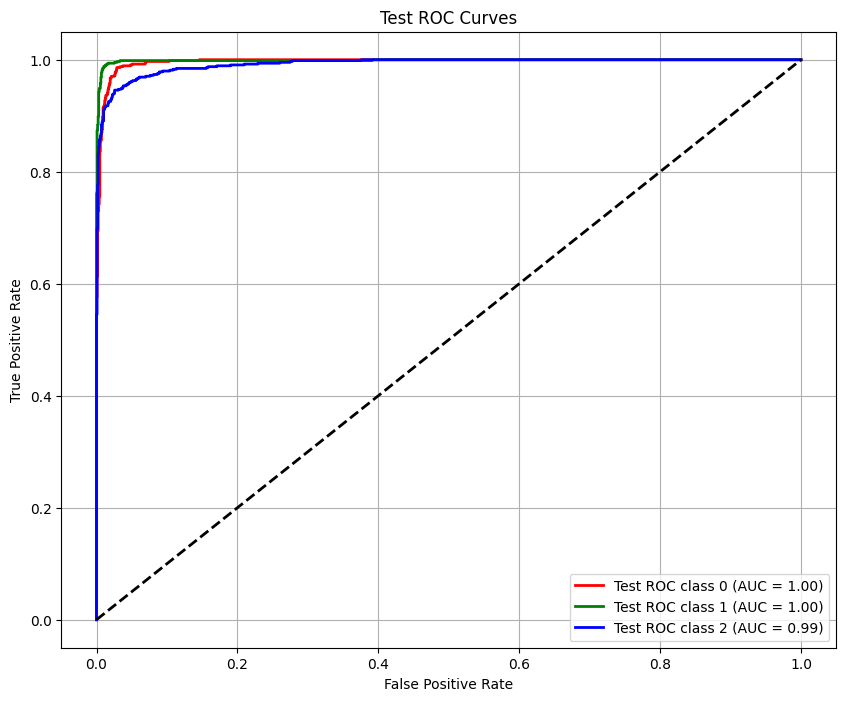


Classification Report on Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2576
           1       1.00      1.00      1.00      2576
           2       1.00      1.00      1.00      2576

    accuracy                           1.00      7728
   macro avg       1.00      1.00      1.00      7728
weighted avg       1.00      1.00      1.00      7728


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       644
           1       0.98      0.98      0.98       644
           2       0.95      0.94      0.94       644

    accuracy                           0.96      1932
   macro avg       0.96      0.96      0.96      1932
weighted avg       0.96      0.96      0.96      1932



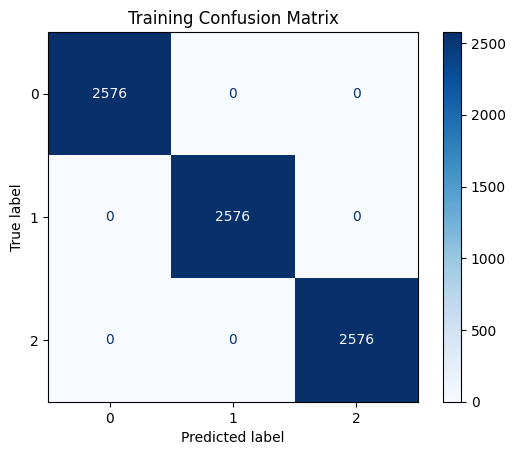

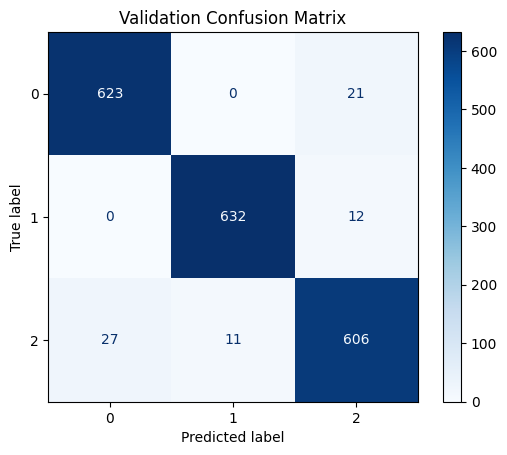

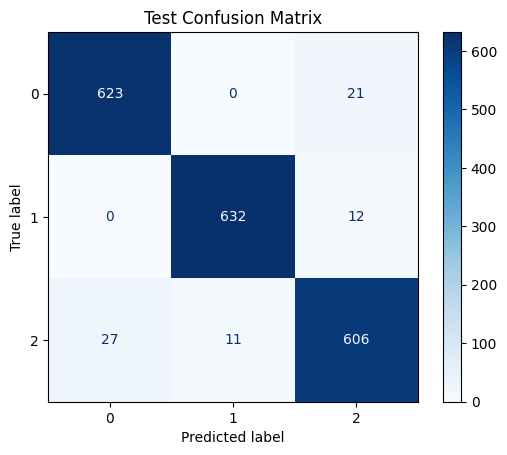

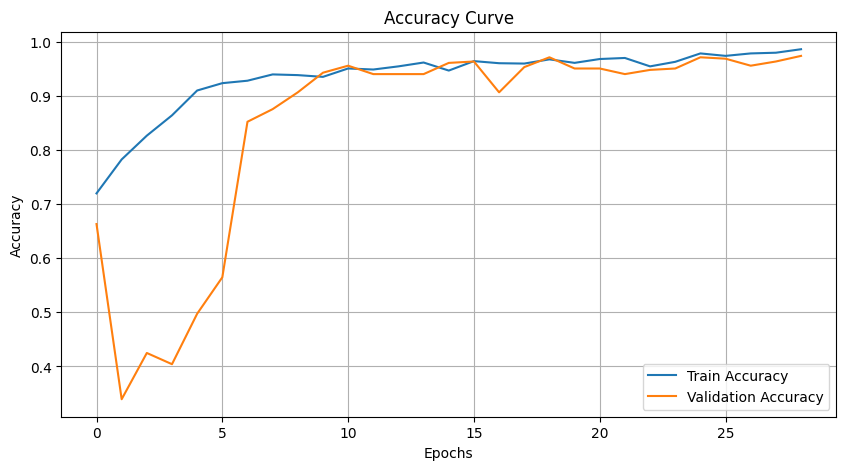

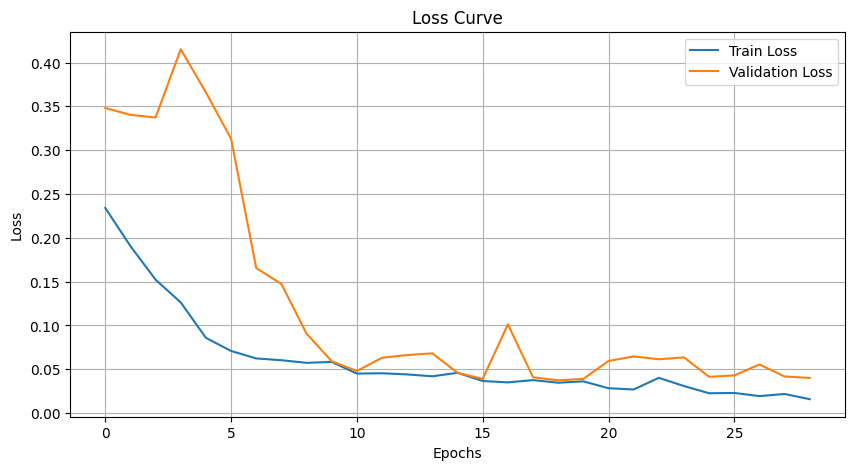

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1. Plot Test ROC Curves
# -----------------------------
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])
all_test_y = np.array(all_valid_y)  # Assuming validation as test
all_test_y_pred_proba = np.array(all_valid_y_pred_proba)

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(all_test_y == i, all_test_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'Test ROC class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 2. Classification Reports
# -----------------------------
all_train_y_pred = np.argmax(np.array(all_train_y_pred_proba), axis=1)
all_test_y_pred = np.argmax(np.array(all_test_y_pred_proba), axis=1)

print("\nClassification Report on Training Data:")
print(classification_report(np.array(all_train_y), all_train_y_pred))

print("\nClassification Report on Test Data:")
print(classification_report(np.array(all_test_y), all_test_y_pred))

# -----------------------------
# 3. Confusion Matrices
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

plot_confusion_matrix(np.array(all_train_y), all_train_y_pred, "Training Confusion Matrix")
plot_confusion_matrix(np.array(all_valid_y), all_valid_y_pred, "Validation Confusion Matrix")
plot_confusion_matrix(np.array(all_test_y), all_test_y_pred, "Test Confusion Matrix")

# -----------------------------
# 4. Accuracy vs Loss Curve
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Saving the model

In [ ]:
model.save("haee_model.keras")

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model, Model

# Load the saved model
model = load_model("haee_model.keras", compile=False)

# Generate a random data point (replace with your actual data generation)
random_data_point = np.random.rand(1, 200, 1)  # Example: a single data point with shape (1, 200, 1)

# Make a prediction
predictions = model.predict(random_data_point)

# Get the predicted class (the class with the highest probability)
predicted_class_index = np.argmax(predictions)

# Map the predicted class index to the class name
class_names = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class and confidence for all classes
print(f"Predicted class: {predicted_class_name}")
for index, confidence in enumerate(predictions[0]):
    class_name = class_names[index]
    print(f"  {class_name}: {confidence*100:.4f}%")
print(f"Hence selected class is {predicted_class_name}")

# List of best features

In [22]:
X_augmented.columns[np.argsort(xgb_fs.feature_importances_)[::-1][:200]].tolist()

['covmat_20_b',
 'wavelet_1',
 'wavelet_0',
 'diff_energy',
 'fft_140_a',
 'correlate_66_a',
 'logm_3_b',
 'max_q_8_a',
 'min_q_3_a',
 'mean_0_b',
 'eigen_2_b',
 'covmat_46_a',
 'logm_3_a',
 'covmat_104_b',
 'covmat_52_a',
 'eigen_0_b',
 'stddev_1_a',
 'covmat_20_a',
 'max_q_32_a',
 'max_q_32_b',
 'stddev_1_b',
 'covmat_65_a',
 'min_q_13_a',
 'covmat_39_a',
 'fft_431_b',
 'max_q_42_a',
 'min_q_12_b',
 'min_q_8_b',
 'logm_9_a',
 'max_2_a',
 'fft_0_b',
 'correlate_69_a',
 'stddev_0_b',
 'fft_567_b',
 'min_q_13_b',
 'stddev_0_a',
 'min_q_17_a',
 'covmat_35_a',
 'min_2_a',
 '# mean_0_a',
 'min_q_18_b',
 'fft_130_a',
 'logm_64_b',
 'fft_445_a',
 'eigen_3_b',
 'mean_d_4_b',
 'wavelet_6',
 'mean_4_b',
 'diff_std',
 'fft_587_a',
 'wavelet_8',
 'logm_6_b',
 'max_q_27_a',
 'correlate_48_b',
 'min_3_b',
 'max_0_a',
 'min_4_a',
 'max_1_b',
 'fft_616_a',
 'max_q_46_a',
 'covmat_0_a',
 'fft_11_a',
 'stddev_2_a',
 'max_q_18_a',
 'mean_d_0_a',
 'fft_611_b',
 'moments_4_a',
 'fft_297_a',
 'fft_420_b',
